# Modeling - Facebook Prophet Model

<a class="anchor" id="content"></a>
### Table of Contents
* [Model #4: FB Prophet w/Dew Point](#Model4)
* [Model #5: FB Propher w/o Dew Point](#Model5)

In this Jupyter Notebook I will be testing runnign the data through the Facebook Prophet model. I will be including the dew point column on the first fitting and reconsider dropping the column after reviewing the results.

In [1]:
# First we wil import the necessary packages for this notebook.
import numpy as np
import pandas as pd
import calendar

# Stats imports
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from prophet import Prophet
import matplotlib.pyplot as plt

# Google Colab imports.
from google.colab import drive
import io


Due to time constraints I troubleshooted an issue with the packages needed to run the FB Prophet model. When the issue was unable to be resolved after a few attempts I moved the notebook to Google Colab.

In [2]:
# Mounting my google drive to have easy access to the dataset.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Uploaded dataset from Google Drive.
file_path = '/content/drive/MyDrive/weatherstats_vancouver_hourly_clean.csv'
df = pd.read_csv(file_path)
df.head()

,date_time_local,pressure_station,pressure_sea,wind_dir,wind_speed,wind_gust,relative_humidity,dew_point,temperature,windchill,humidex,visibility,health_index,cloud_okta,max_air_temp_pst1hr,min_air_temp_pst1hr
0,2013-07-01 00:00:00,101.18,101.16,SSE,7,0.0,91,18.2,19.7,0.0,0.0,32200.0,2.9,5.0,19.4,18.5
1,2013-07-01 01:00:00,101.22,101.21,SE,6,0.0,89,17.8,19.6,0.0,0.0,32200.0,3.0,5.0,20.1,18.7
2,2013-07-01 02:00:00,101.26,101.24,E,11,0.0,88,16.7,18.7,0.0,0.0,32200.0,3.0,5.0,19.8,18.0
3,2013-07-01 03:00:00,101.26,101.25,E,4,0.0,84,16.5,19.2,0.0,0.0,32200.0,2.7,5.0,18.5,17.5
4,2013-07-01 04:00:00,101.30,101.28,NNW,5,0.0,87,15.7,17.9,0.0,0.0,32200.0,2.6,5.0,18.8,17.3


In [4]:
# Setting the Date column to data type "Datetime"
df['date_time_local'] = pd.to_datetime(df['date_time_local'], utc=False)

In [5]:
# As previously established in the EDA portion, these four columns will be dropped.
df4 = df.drop(['max_air_temp_pst1hr', 'min_air_temp_pst1hr', 'pressure_sea', 'wind_dir'], axis=1)

Prophet is different in that it gets the timeseries information from the dataset via a column designated as "ds". The target variable also has to be designated to a "y".

In [6]:
df4 = df.rename(columns={"date_time_local": "ds", "temperature": "y"})

In [7]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87648 entries, 0 to 87647
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ds                   87648 non-null  datetime64[ns]
 1   pressure_station     87648 non-null  float64       
 2   pressure_sea         87648 non-null  float64       
 3   wind_dir             87648 non-null  object        
 4   wind_speed           87648 non-null  int64         
 5   wind_gust            87648 non-null  float64       
 6   relative_humidity    87648 non-null  int64         
 7   dew_point            87648 non-null  float64       
 8   y                    87648 non-null  float64       
 9   windchill            87648 non-null  float64       
 10  humidex              87648 non-null  float64       
 11  visibility           87648 non-null  float64       
 12  health_index         87648 non-null  float64       
 13  cloud_okta           87648 non-

##### [***To Top***](#content)

<a class="anchor" id="Model4"></a>
## Model #4: Facebook Prophet with Regressors (including Dew Point)

In [8]:
# The data will be split before and after June 30, 2020 using the "ds" column from above for it.
train_data_4 = df4[df4['ds'] <= '2020-06-30']
test_data_4= df4[df4['ds']>"2020-06-30"]

In [9]:
# Printing the shape of the data to check the split was succesful.
print(f" train_data 4 Shape is: {train_data_4.shape}")
print(f" test_data Shape is: {test_data_4.shape}")

 train_data 4 Shape is: (61345, 16)
 test_data Shape is: (26303, 16)


In [10]:
# This is the 4th model being considered in this project.
model_4 = Prophet()

In [11]:
# Here I initiate a for loop to go over the variables and add a regressor for each. This allows for multivariate handling inside the prophet model.
for column in ['pressure_station', 'wind_speed', 'wind_gust', 'relative_humidity', 'dew_point', 'windchill', 'humidex', 'visibility', 'health_index', 'cloud_okta']:
    model_4.add_regressor(column)

# Fitting the model with the training data
model_4.fit(train_data_4)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpa_dqhtrf/fix7hx5d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa_dqhtrf/8mx6y3z_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9963', 'data', 'file=/tmp/tmpa_dqhtrf/fix7hx5d.json', 'init=/tmp/tmpa_dqhtrf/8mx6y3z_.json', 'output', 'file=/tmp/tmpa_dqhtrf/prophet_modelos3c_mga/prophet_model-20230905034015.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:40:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:41:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [12]:
forecast_train_4 = model_4.predict(train_data_4)
forecast_test_4 = model_4.predict(test_data_4)

In [13]:
# This function is to define the mape, which will be used to evaluate the models.
def mean_absolute_percentage_error(true_values, predicted_values):
    """
    Calculate the mean absolute percentage error.
    Find the prediction error and devide by the true value, then average.
    """
    # Filter out the zero values to avoid division by zero
    mask = true_values != 0
    true_values = true_values[mask]
    predicted_values = predicted_values[mask]

    error = true_values - predicted_values
    absolute_percentage_error = np.abs(error/true_values)
    mape = absolute_percentage_error.mean() * 100

    return mape

In [14]:
# Extracting the predicted and true values for the training data. The 'yhat' column was created by the prophet model in the .predict() stage, it includes the predictions.
y_train_pred_4 = forecast_train_4['yhat']
y_train_true_4 = train_data_4['y']

# Computing the metrics for training data
train_mae_4 = mean_absolute_error(y_train_true_4, y_train_pred_4)
train_mse_4 = mean_squared_error(y_train_true_4, y_train_pred_4)
train_rmse_4 = np.sqrt(train_mse_4)
train_mape_4 = mean_absolute_percentage_error(y_train_true_4, y_train_pred_4)
train_r2_4 = r2_score(y_train_true_4, y_train_pred_4)

print(f'''Training Data:
Mean Absolute Error: {round(train_mae_4, 4)}
Mean Squared Error: {round(train_mse_4, 4)}
Root Mean Squared Error: {round(train_rmse_4, 4)}
Mean Absolute Percentage Error: {round(train_mape_4, 2)}%
R-squared: {train_r2_4}''')

# Extracting the predicted and true values for the test data
y_pred_4 = forecast_test_4['yhat']
y_true_4 = test_data_4['y']

# Data is not the index so the train/test split is causing an index error.
# Resetting indexes to fix.
y_pred_4 = forecast_test_4['yhat'].reset_index(drop=True)
y_true_4 = test_data_4['y'].reset_index(drop=True)

# Computing the metris for the test data
mae_4 = mean_absolute_error(y_true_4, y_pred_4)
mse_4 = mean_squared_error(y_true_4, y_pred_4)
rmse_4 = np.sqrt(mse_4)
mape_4 = mean_absolute_percentage_error(y_true_4, y_pred_4)
r2_4 = r2_score(y_true_4, y_pred_4)

print(f'''Test Data:
Mean Absolute Error: {round(mae_4, 4)}
Mean Squared Error: {round(mse_4, 4)}
Root Mean Squared Error: {round(rmse_4, 4)}
Mean Absolute Percentage Error: {round(mape_4, 2)}%
R-squared: {r2_4}''')

Training Data:
Mean Absolute Error: 0.2202
Mean Squared Error: 0.115
Root Mean Squared Error: 0.3391
Mean Absolute Percentage Error: 6.46%
R-squared: 0.9970757051830795
Test Data:
Mean Absolute Error: 0.3193
Mean Squared Error: 0.201
Root Mean Squared Error: 0.4483
Mean Absolute Percentage Error: 8.33%
R-squared: 0.9953122737748541


| Metric                        | Training Data | Test Data   |
|-------------------------------|--------------|------------|
| Mean Absolute Error           | 0.2202       | 0.3193     |
| Mean Squared Error            | 0.115       | 0.201      |
| Root Mean Squared Error       | 0.3391       | 0.4484     |
| Mean Absolute Percentage Error| 6.46%        | 8.33%      |
| R-squared                     | 0.9970       | 0.9953     |

Model #4 seems to be performing well. the R-Squared value is very high, which should indicate near perfect predictions. However, the rest of the metrics do not indicate this. The low MAE indicates the average of the differences from predicted vs. actual values. The low MSE would be an indicator that there are few large errors in the predictions, but the RMSE is higher than MSE and MAE, which suggests there are actually some large errors to consider. The MAPE is also low, which indicates a low error rate.
</br>
I will be plotting the predicted vs. actual values for the test and train data to look visualize the errors.

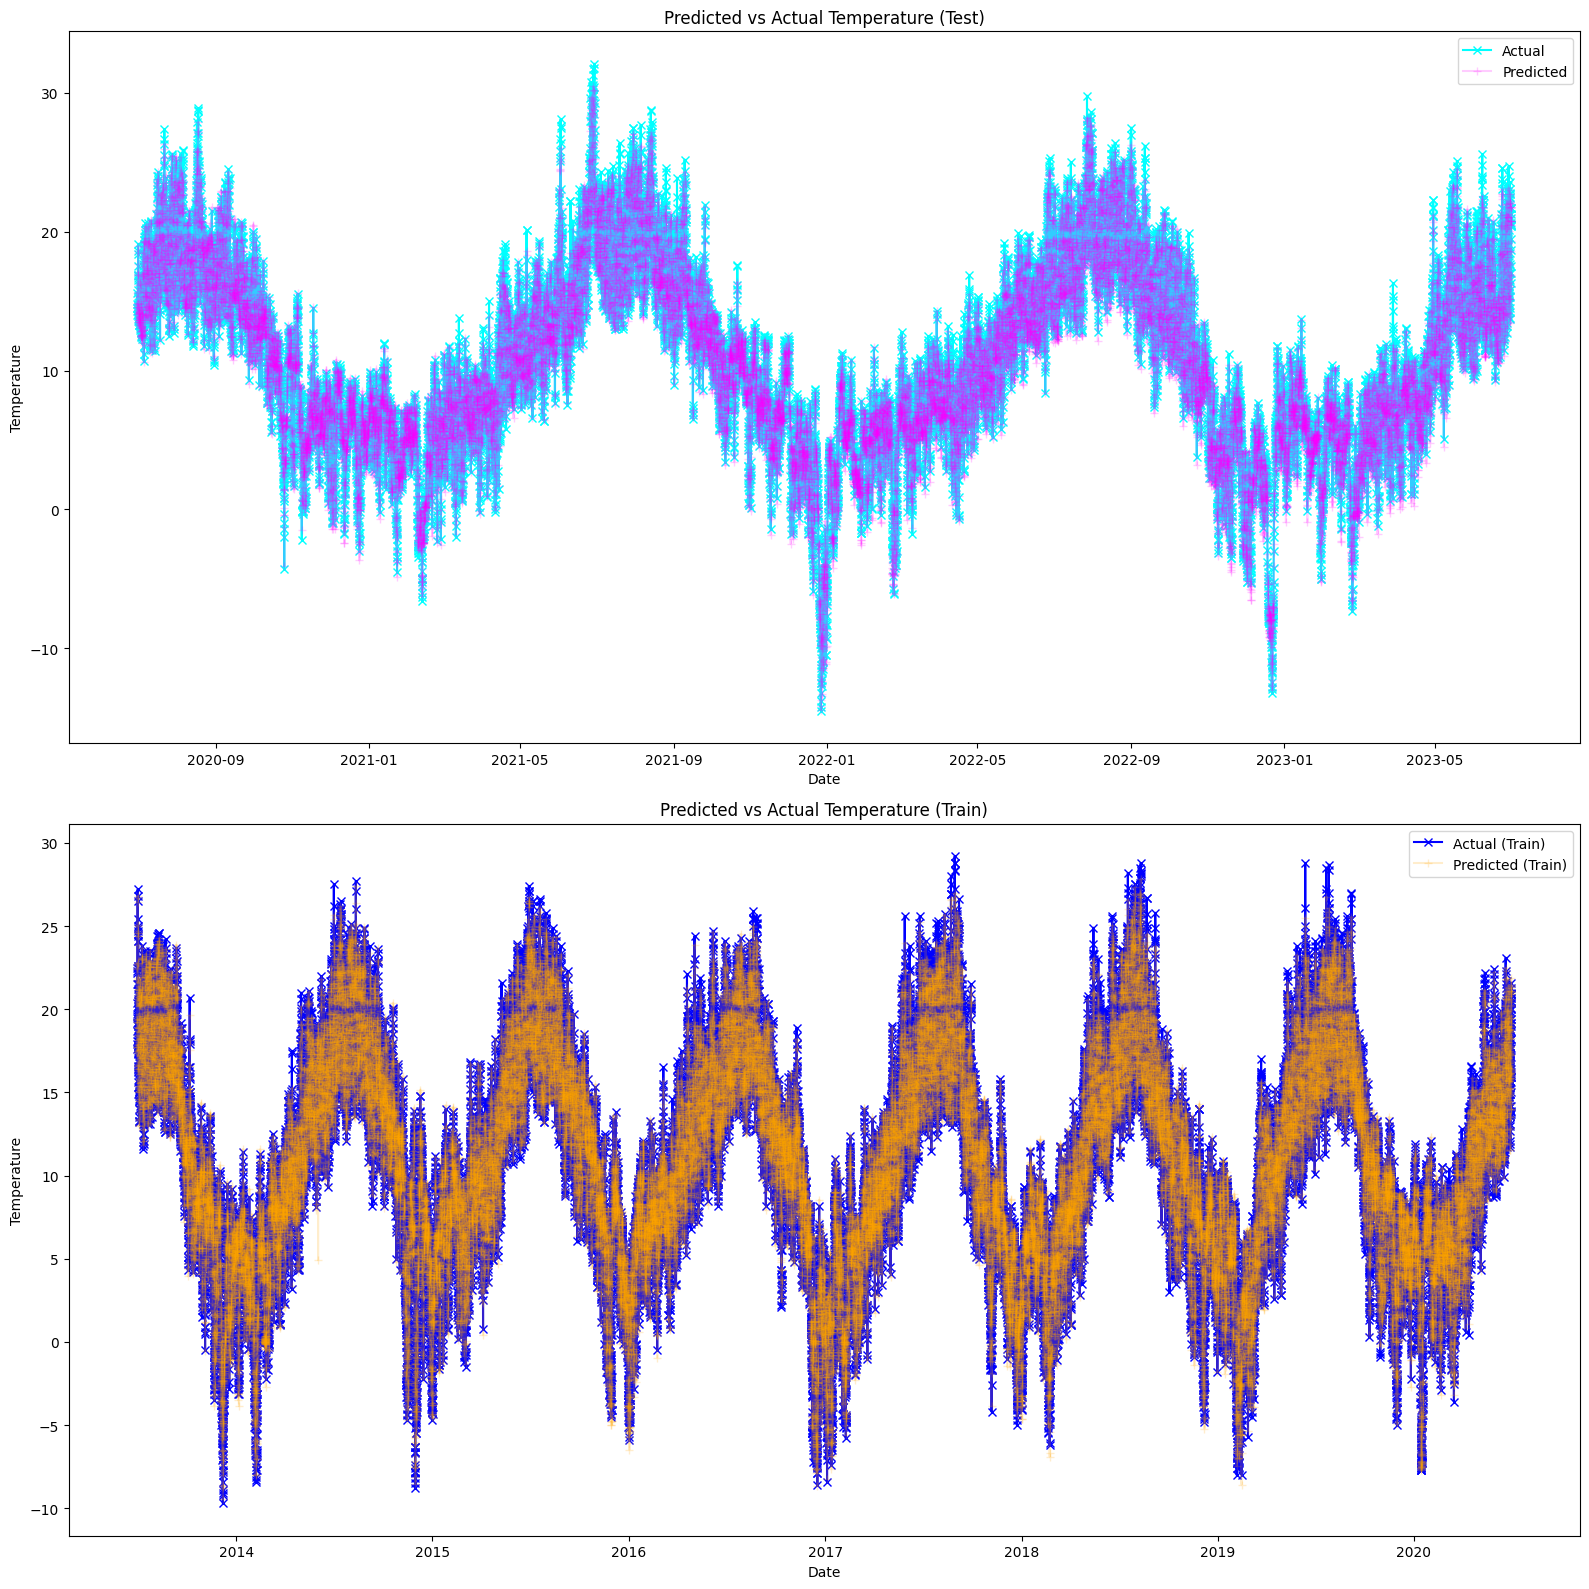

In [15]:
# Below I will plot the test predictions vs. actuals and then the train predictions vs. actuals.
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 16))

# First subplot: Test Data
axes[0].plot(test_data_4['ds'], y_true_4, label='Actual', marker='x', color='cyan')
axes[0].plot(test_data_4['ds'], y_pred_4, label='Predicted', marker='+', color='magenta', alpha=.2)
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Temperature')
axes[0].set_title('Predicted vs Actual Temperature (Test)')
axes[0].legend()

# Second subplot: Train Data
axes[1].plot(train_data_4['ds'], y_train_true_4, label='Actual (Train)', marker='x', color='blue')
axes[1].plot(train_data_4['ds'], y_train_pred_4, label='Predicted (Train)', marker='+', color='orange', alpha=.2)
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Temperature')
axes[1].set_title('Predicted vs Actual Temperature (Train)')
axes[1].legend()

plt.tight_layout()
plt.show()

Per the above graph, it looks like Model #4 is particularly good at predicting the values for the very low temperatures, but its not accurate when it comes to very high temperatures.

##### [***To Top***](#content)

<a class="anchor" id="Model5"></a>
## Model #5: Facebook Prophet with Regressors (excluding Dew Point)

In [16]:
# In this model we will drop the previous columns we discussed and dew point as well.
df_5 = df.drop(['max_air_temp_pst1hr', 'min_air_temp_pst1hr', 'pressure_sea', 'wind_dir', 'dew_point'], axis=1)

In [17]:
# In this new data we also need to rename the columns for the prophet model as before.
df_5 = df_5.rename(columns={"date_time_local": "ds", "temperature": "y"})

In [18]:
# The data will again be split before and after June 30, 2020 using the "ds" column.
train_data_5 = df_5[df_5['ds'] <= '2020-06-30']
test_data_5 = df_5[df_5['ds']>"2020-06-30"]

In [19]:
# This serves to double check the split and can be compared to the split on the previous model (notice this one has 11 variables instead of 12)
print(f" train_data Shape is: {train_data_5.shape}")
print(f" test_data Shape is: {train_data_5.shape}")

 train_data Shape is: (61345, 11)
 test_data Shape is: (61345, 11)


In [20]:
# This is the 5th model being considered for this project.
model_5 = Prophet()

In [21]:
# Same as before, each variable is looped through and a regressor is added to the model for each.
for column in ['pressure_station', 'wind_speed', 'wind_gust', 'relative_humidity', 'windchill', 'humidex', 'visibility', 'health_index', 'cloud_okta']:
    model_5.add_regressor(column)

# I can now fit the model with the training data, this time without the dew point.
model_5.fit(train_data_5)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpa_dqhtrf/hs8eyzrc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa_dqhtrf/uudpvd5e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79682', 'data', 'file=/tmp/tmpa_dqhtrf/hs8eyzrc.json', 'init=/tmp/tmpa_dqhtrf/uudpvd5e.json', 'output', 'file=/tmp/tmpa_dqhtrf/prophet_model7fqtzfw7/prophet_model-20230905034218.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:42:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:43:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [22]:
forecast_train_5 = model_5.predict(train_data_5)
forecast_test_5 = model_5.predict(test_data_5)

In [23]:
# Extracting the predicted and true values for the training data. The 'yhat' column was created by the prophet model in the .predict() stage, it includes the predictions.
y_train_pred_5 = forecast_train_5['yhat']
y_train_true_5 = train_data_5['y']

# Computing the metrics for training data
train_mae_5 = mean_absolute_error(y_train_true_5, y_train_pred_5)
train_mse_5 = mean_squared_error(y_train_true_5, y_train_pred_5)
train_rmse_5 = np.sqrt(train_mse_5)
train_mape_5 = mean_absolute_percentage_error(y_train_true_5, y_train_pred_5)
train_r2_5 = r2_score(y_train_true_5, y_train_pred_5)

print(f'''Training Data:
Mean Absolute Error: {round(train_mae_5, 4)}
Mean Squared Error: {round(train_mse_5, 4)}
Root Mean Squared Error: {round(train_rmse_5, 4)}
Mean Absolute Percentage Error: {round(train_mape_5, 2)}%
R-squared: {train_r2_5}''')

# Extracting the predicted and true values for the test data
y_pred_5 = forecast_test_5['yhat']
y_true_5 = test_data_5['y']

# Data is not the index so the train/test split is causing an index error.
# Resetting indexes to fix.
y_pred_5 = forecast_test_5['yhat'].reset_index(drop=True)
y_true_5 = test_data_5['y'].reset_index(drop=True)

# Computing the metris for the test data
mae_5 = mean_absolute_error(y_true_5, y_pred_5)
mse_5 = mean_squared_error(y_true_5, y_pred_5)
rmse_5 = np.sqrt(mse_5)
mape_5 = mean_absolute_percentage_error(y_true_5, y_pred_5)
r2_5 = r2_score(y_true_5, y_pred_5)

print(f'''Test Data:
Mean Absolute Error: {round(mae_5, 4)}
Mean Squared Error: {round(mse_5, 4)}
Root Mean Squared Error: {round(rmse_5, 4)}
Mean Absolute Percentage Error: {round(mape_5, 2)}%
R-squared: {r2_5}''')

Training Data:
Mean Absolute Error: 1.5701
Mean Squared Error: 4.0271
Root Mean Squared Error: 2.0068
Mean Absolute Percentage Error: 48.32%
R-squared: 0.897612285115648
Test Data:
Mean Absolute Error: 1.8077
Mean Squared Error: 5.2493
Root Mean Squared Error: 2.2911
Mean Absolute Percentage Error: 48.86%
R-squared: 0.8775593656615084


| Metric                         | Training Data         | Test Data            |
|--------------------------------|-----------------------|----------------------|
| Mean Absolute Error            | 1.5701                | 1.8077               |
| Mean Squared Error             | 4.0271                | 5.2493               |
| Root Mean Squared Error        | 2.0068                | 2.2911               |
| Mean Absolute Percentage Error | 48.32%                | 48.86%               |
| R-squared                      | 0.8976                | 0.8776               |


Similar to model #3 (linear regression), excluding dew point lowers the accuracy of this model. The R-squared metric only dropped 10%, but The MAE, MSE, RMSE, and MAPE all went up suggesting increased errors in the prediction vs. actual.
</br>
Like with model #5 I will now visualize the results to look at how the predictions look over the actual values of temperature.

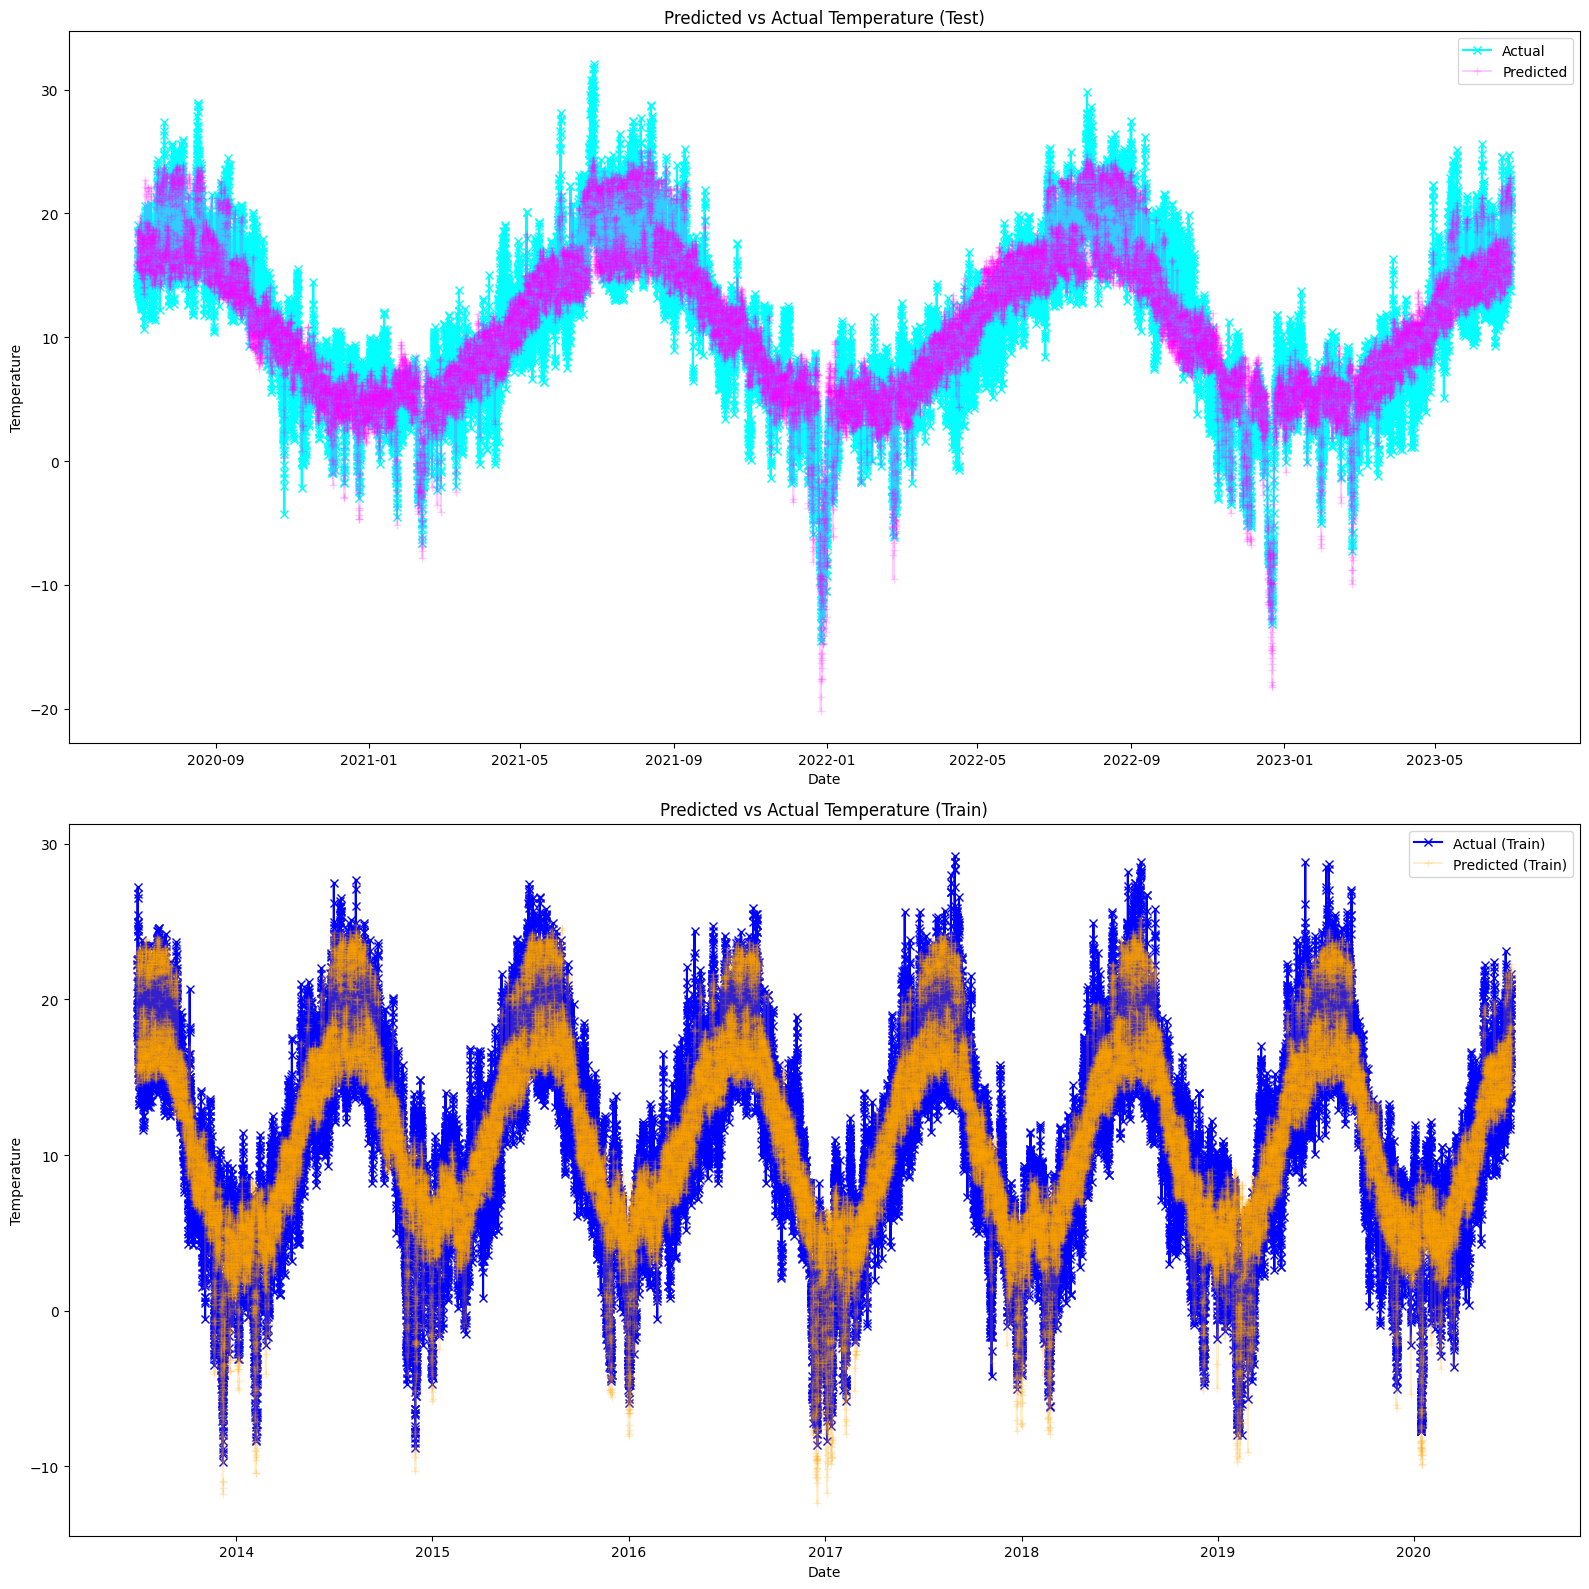

In [24]:
# I can now plot the test predictions vs. actuals as well as the train predictions vs. actuals for model #5.
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 16))

# First subplot: Test Data
axes[0].plot(test_data_5['ds'], y_true_5, label='Actual', marker='x', color='cyan')
axes[0].plot(test_data_5['ds'], y_pred_5, label='Predicted', marker='+', color='magenta', alpha=.2)
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Temperature')
axes[0].set_title('Predicted vs Actual Temperature (Test)')
axes[0].legend()

# Second subplot: Train Data
axes[1].plot(train_data_5['ds'], y_train_true_5, label='Actual (Train)', marker='x', color='b')
axes[1].plot(train_data_5['ds'], y_train_pred_5, label='Predicted (Train)', marker='+', color='orange', alpha=.2)
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Temperature')
axes[1].set_title('Predicted vs Actual Temperature (Train)')
axes[1].legend()

plt.tight_layout()
plt.show()

The predictions in Model #5 miss the mark on the low temperatures and tend to exceed the actual values by a lot. This model is also not predicting the high temperatures accurately.

The prophet models do not seem to be the best match for the prediction of highest and lowest temperatures. I will be exploring LSTM in the next notebook.